In [1]:
import os, json, torch, random
import numpy as np
from monai import transforms
from monai.data import DataLoader, DistributedSampler
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from monai.networks.nets.swin_unetr import SwinUNETR
from monai.inferers import sliding_window_inference
from functools import partial
import matplotlib.pyplot as plt
from models.SuperFormer import SuperFormer
import nibabel as nib

In [2]:
class MRIDataset(Dataset):
    def downsample_mri_kspace(self, mri_image, downsampling_factor):
        """
        Downsamples an MRI image using k-space zero-filling.
        """
        # Get the image data and affine transformation
        data = mri_image[0]

        # Get the spatial dimensions
        spatial_dims = data.shape[:len(downsampling_factor)]
        num_spatial_dims = len(spatial_dims)

        # Check if the downsampling factor is valid
        if len(downsampling_factor) != num_spatial_dims:
            raise ValueError(f"Downsampling factor length ({len(downsampling_factor)}) must match the number of spatial dimensions ({num_spatial_dims}).")
        for factor in downsampling_factor:
            if not isinstance(factor, int) or factor < 1:
                raise ValueError("Downsampling factors must be positive integers.")

        # Perform k-space transform
        k_space = np.fft.fftn(data, axes=range(num_spatial_dims))
        k_space_shifted = np.fft.fftshift(k_space, axes=range(num_spatial_dims))

        # Create a new k-space array with zero-filling
        new_k_space_shape = list(k_space_shifted.shape)

        # Determine the central portion to keep in k-space
        start_indices = []
        end_indices = []
        for i in range(num_spatial_dims):
            center = spatial_dims[i] // 2
            half_kept = (spatial_dims[i] // downsampling_factor[i]) // 2
            start_indices.append(center - half_kept)
            end_indices.append(center + (spatial_dims[i] // downsampling_factor[i]) - half_kept)
            new_k_space_shape[i] = spatial_dims[i] // downsampling_factor[i]

        # Place the central portion of the original k-space into the new (larger) array
        slices = tuple(slice(start, end) for start, end in zip(start_indices, end_indices))
        # downsampled_k_space_shifted[slices] = k_space_shifted[slices]
        downsampled_k_space_shifted = k_space_shifted[slices]

        # Inverse k-space transform to get the downsampled image
        downsampled_k_space = np.fft.ifftshift(downsampled_k_space_shifted, axes=range(num_spatial_dims))
        downsampled_data = np.fft.ifftn(downsampled_k_space, axes=range(num_spatial_dims)).real
        downsampled_data = downsampled_data[np.newaxis, ...]  # Add a new axis to match the original shape

        return downsampled_data

    def __init__(self, image_paths, type, resample_factors):
        self.image_paths = image_paths
        self.resample_factors = resample_factors
        self.train_transform_1 = transforms.Compose([
            transforms.CopyItemsd(keys=[type], names=['path']),
            transforms.LoadImaged(keys=[type]),
            transforms.CopyItemsd(keys=[type], names=['image']),
            transforms.DeleteItemsd(keys=[type]),
            transforms.EnsureChannelFirstd(keys=["image"]),
            transforms.EnsureTyped(keys=["image"]),
            transforms.Orientationd(keys=["image"], axcodes="RAS"),
            transforms.ScaleIntensityRangePercentilesd(keys=["image"], lower=0.5, upper=99.5, b_min=0, b_max=1,clip=True ),
            transforms.Spacingd(keys=['image'],pixdim=(1,1,1),mode="nearest"),
            transforms.ResizeWithPadOrCropd(keys=['image'],spatial_size=(240,240,160)),
            transforms.CopyItemsd(keys=['image'], names=['hi_res','low_res'], times=2),
            transforms.DeleteItemsd(keys=['image']),])
        self.train_transform_2 = transforms.Compose([
            transforms.Resized(keys=["low_res"], spatial_size=(240,240,160), mode="nearest"),
        ])
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        data = self.image_paths[idx]
        transformed_data = self.train_transform_1(data)
        # transformed_data['low_res'] = self.downsample_mri_kspace(transformed_data['low_res'],self.resample_factors)
        # transformed_data = self.train_transform_2(transformed_data)
        return transformed_data

In [3]:
with open('json/short_list.json') as f:
    test_pair = json.load(f)
    print(len(test_pair))
random.seed(0)
random.shuffle(test_pair)
test_pair = test_pair

100


In [4]:
down_sample = 4
test_ds = MRIDataset(test_pair,type='fl', resample_factors = (1, 1, 4))
test_loader = DataLoader(test_ds, batch_size=2, shuffle=False, num_workers=2, persistent_workers=True)#'path', 'hi_res', 'low_res'

In [5]:
model = SuperFormer(upscale=1,
                   patch_size = 2,
                   in_chans=1,
                   img_size=64,
                   window_size=8,
                   img_range=1.0,
                   depths=[6, 6, 6],
                   embed_dim=240,
                   num_heads=[6, 6, 6],
                   mlp_ratio=2,
                   upsampler=None,
                   resi_connection="1conv",
                   ape=False, 
                   rpb=True,
                   output_type = "direct",
                   num_feat = 126)
# model.load_state_dict(torch.load('./checkpoint_superformer/pytorch_model.bin',weights_only=True))
model.load_state_dict(torch.load('./checkpoint_superformer/siglip_latest.pt',weights_only=True))
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model_inferer = partial(
    sliding_window_inference,
    roi_size=[64, 64, 64],
    sw_batch_size=20,
    predictor=model,
    overlap=0.6,
)

In [16]:
high_res_folder = './Infer/high_res'
low_res_folder = f'./Infer/low_res_{down_sample}'
recon_folder = f'./Infer/recon_{down_sample}'
if not os.path.exists(high_res_folder):
    os.makedirs(high_res_folder)
if not os.path.exists(low_res_folder):
    os.makedirs(low_res_folder)
if not os.path.exists(recon_folder):
    os.makedirs(recon_folder)
output_list = []
with torch.no_grad():
    with torch.autocast(device_type="cuda" , dtype=torch.bfloat16):
        for batch_data in tqdm(test_loader):
            paths = batch_data["path"]
            image = batch_data["hi_res"].to(device)
            low_res = batch_data["low_res"].to(device)
            output = model_inferer(low_res)
            output = model_inferer(output)
            high_res = image.cpu().float().numpy()
            low_res = low_res.cpu().float().numpy()
            recon = output.cpu().float().numpy()
            B,C,H,W,D = high_res.shape
            for i in range(B):
                path = paths[i]
                basename = os.path.basename(path)
                tnum = path.split('/')[-1].split('_')[0]
                low_res_image = low_res[i,0,:,:,:]
                recon_image = recon[i,0,:,:,:]
                high_res_image = high_res[i,0,:,:,:]
                
                raw_nib = nib.load(path)
                spacing = raw_nib.header['pixdim'][1:4]
                spacing[2] = 1.0
                nib_size = raw_nib.shape
                nib_size = list(nib_size)
                high_size = high_res_image.shape
                nib_size[2] = high_size[2]
                affine = np.eye(4)
                affine[:3,:3] = np.diag(spacing)
                transfrom_infer = transforms.Compose([
                    transforms.EnsureChannelFirst(channel_dim=0),
                    transforms.Spacing(pixdim=spacing,mode='bilinear'),
                    transforms.ResizeWithPadOrCrop(spatial_size=nib_size),
                    ])
                low_res_image = transfrom_infer(low_res_image[np.newaxis,:,:,:].copy())[0].numpy()
                recon_image = transfrom_infer(recon_image[np.newaxis,:,:,:].copy())[0].numpy()
                high_res_image = transfrom_infer(high_res_image[np.newaxis,:,:,:].copy())[0].numpy()

                low_res_nib = nib.Nifti1Image(low_res_image.astype(np.float32),affine)
                recon_nib = nib.Nifti1Image(recon_image.astype(np.float32),affine)
                high_res_nib = nib.Nifti1Image(high_res_image.astype(np.float32),affine)
                hig_path = f'{high_res_folder}/{tnum}'
                os.makedirs(hig_path,exist_ok=True)
                low_path = f'{low_res_folder}/{tnum}'
                os.makedirs(low_path,exist_ok=True)
                recon_path = f'{recon_folder}/{tnum}'
                os.makedirs(recon_path,exist_ok=True)

                nib.save(high_res_nib,os.path.join(hig_path,basename))
                nib.save(low_res_nib,os.path.join(low_path,basename))
                nib.save(recon_nib,os.path.join(recon_path,basename))
                print(os.path.join(recon_path,basename))
                output_list.append({'high_res':os.path.join(hig_path,basename),'low_res':os.path.join(low_path,basename),'recon':os.path.join(recon_path,basename)})
            # break

  0%|          | 0/50 [00:00<?, ?it/s]

./Infer/recon_4/t15923/t15923_fl_bet.nii.gz


  2%|▏         | 1/50 [09:07<7:27:26, 547.88s/it]

./Infer/recon_4/t5860/t5860_fl_bet.nii.gz
./Infer/recon_4/t5554/t5554_fl_bet.nii.gz


  4%|▍         | 2/50 [18:12<7:16:51, 546.07s/it]

./Infer/recon_4/t5314/t5314_fl_bet.nii.gz
./Infer/recon_4/t12014/t12014_fl_bet.nii.gz


  6%|▌         | 3/50 [27:18<7:07:33, 545.82s/it]

./Infer/recon_4/t5243/t5243_fl_bet.nii.gz
./Infer/recon_4/t10119/t10119_fl_bet.nii.gz


  8%|▊         | 4/50 [36:37<7:02:30, 551.11s/it]

./Infer/recon_4/t5668/t5668_fl_bet.nii.gz
./Infer/recon_4/t6020/t6020_fl_bet.nii.gz


 10%|█         | 5/50 [45:43<6:51:54, 549.21s/it]

./Infer/recon_4/t4977/t4977_fl_bet.nii.gz
./Infer/recon_4/t6034/t6034_fl_bet.nii.gz


 12%|█▏        | 6/50 [55:00<6:44:49, 552.03s/it]

./Infer/recon_4/t5845/t5845_fl_bet.nii.gz
./Infer/recon_4/t12074/t12074_fl_bet.nii.gz


 14%|█▍        | 7/50 [1:04:07<6:34:25, 550.35s/it]

./Infer/recon_4/t16204/t16204_fl_bet.nii.gz
./Infer/recon_4/t6062/t6062_fl_bet.nii.gz


 16%|█▌        | 8/50 [1:13:11<6:23:51, 548.37s/it]

./Infer/recon_4/t5648/t5648_fl_bet.nii.gz
./Infer/recon_4/t9990/t9990_fl_bet.nii.gz


 18%|█▊        | 9/50 [1:22:15<6:13:45, 546.97s/it]

./Infer/recon_4/t10724/t10724_fl_bet.nii.gz
./Infer/recon_4/t16348/t16348_fl_bet.nii.gz


 20%|██        | 10/50 [1:31:39<6:08:02, 552.05s/it]

./Infer/recon_4/t16396/t16396_fl_bet.nii.gz
./Infer/recon_4/t7935/t7935_fl_bet.nii.gz


 22%|██▏       | 11/50 [1:40:43<5:57:13, 549.58s/it]

./Infer/recon_4/t5811/t5811_fl_bet.nii.gz
./Infer/recon_4/t15410/t15410_fl_bet.nii.gz


 24%|██▍       | 12/50 [1:49:50<5:47:34, 548.81s/it]

./Infer/recon_4/t12751/t12751_fl_bet.nii.gz
./Infer/recon_4/t12334/t12334_fl_bet.nii.gz


 26%|██▌       | 13/50 [1:58:56<5:37:55, 547.98s/it]

./Infer/recon_4/t5682/t5682_fl_bet.nii.gz
./Infer/recon_4/t14386/t14386_fl_bet.nii.gz


 28%|██▊       | 14/50 [2:08:16<5:31:05, 551.81s/it]

./Infer/recon_4/t6122/t6122_fl_bet.nii.gz
./Infer/recon_4/t15320/t15320_fl_bet.nii.gz


 30%|███       | 15/50 [2:17:36<5:23:20, 554.29s/it]

./Infer/recon_4/t5569/t5569_fl_bet.nii.gz
./Infer/recon_4/t6688/t6688_fl_bet.nii.gz


 32%|███▏      | 16/50 [2:27:11<5:17:28, 560.26s/it]

./Infer/recon_4/t7858/t7858_fl_bet.nii.gz
./Infer/recon_4/t5015/t5015_fl_bet.nii.gz


 34%|███▍      | 17/50 [2:36:17<5:05:51, 556.12s/it]

./Infer/recon_4/t5172/t5172_fl_bet.nii.gz
./Infer/recon_4/t9476/t9476_fl_bet.nii.gz


 36%|███▌      | 18/50 [2:45:37<4:57:11, 557.23s/it]

./Infer/recon_4/t2806/t2806_fl_bet.nii.gz
./Infer/recon_4/t6321/t6321_fl_bet.nii.gz


 38%|███▊      | 19/50 [2:55:05<4:49:39, 560.63s/it]

./Infer/recon_4/t14028/t14028_fl_bet.nii.gz
./Infer/recon_4/t8626/t8626_fl_bet.nii.gz


 40%|████      | 20/50 [3:04:12<4:38:16, 556.55s/it]

./Infer/recon_4/t5011/t5011_fl_bet.nii.gz
./Infer/recon_4/t9495/t9495_fl_bet.nii.gz


 42%|████▏     | 21/50 [3:13:18<4:27:27, 553.36s/it]

./Infer/recon_4/t8547/t8547_fl_bet.nii.gz
./Infer/recon_4/t16262/t16262_fl_bet.nii.gz


 44%|████▍     | 22/50 [3:22:39<4:19:12, 555.45s/it]

./Infer/recon_4/t3241/t3241_fl_bet.nii.gz
./Infer/recon_4/t14415/t14415_fl_bet.nii.gz


 46%|████▌     | 23/50 [3:31:46<4:08:48, 552.92s/it]

./Infer/recon_4/t9721/t9721_fl_bet.nii.gz
./Infer/recon_4/t9115/t9115_fl_bet.nii.gz


 48%|████▊     | 24/50 [3:41:06<4:00:30, 555.01s/it]

./Infer/recon_4/t5363/t5363_fl_bet.nii.gz
./Infer/recon_4/t14315/t14315_fl_bet.nii.gz


 50%|█████     | 25/50 [3:50:21<3:51:17, 555.12s/it]

./Infer/recon_4/t7493/t7493_fl_bet.nii.gz
./Infer/recon_4/t12761/t12761_fl_bet.nii.gz


 52%|█████▏    | 26/50 [3:59:54<3:44:13, 560.57s/it]

./Infer/recon_4/t15074/t15074_fl_bet.nii.gz
./Infer/recon_4/t9581/t9581_fl_bet.nii.gz


 54%|█████▍    | 27/50 [4:09:13<3:34:43, 560.13s/it]

./Infer/recon_4/t7856/t7856_fl_bet.nii.gz
./Infer/recon_4/t7876/t7876_fl_bet.nii.gz


 56%|█████▌    | 28/50 [4:18:20<3:23:51, 555.98s/it]

./Infer/recon_4/t8057/t8057_fl_bet.nii.gz
./Infer/recon_4/t5561/t5561_fl_bet.nii.gz


 58%|█████▊    | 29/50 [4:27:28<3:13:49, 553.78s/it]

./Infer/recon_4/t9336/t9336_fl_bet.nii.gz
./Infer/recon_4/t7828/t7828_fl_bet.nii.gz


 60%|██████    | 30/50 [4:36:43<3:04:42, 554.12s/it]

./Infer/recon_4/t5730/t5730_fl_bet.nii.gz
./Infer/recon_4/t6151/t6151_fl_bet.nii.gz


 62%|██████▏   | 31/50 [4:45:46<2:54:26, 550.86s/it]

./Infer/recon_4/t11826/t11826_fl_bet.nii.gz
./Infer/recon_4/t5345/t5345_fl_bet.nii.gz


 64%|██████▍   | 32/50 [4:54:48<2:44:22, 547.92s/it]

./Infer/recon_4/t5307/t5307_fl_bet.nii.gz
./Infer/recon_4/t6087/t6087_fl_bet.nii.gz


 66%|██████▌   | 33/50 [5:03:55<2:35:13, 547.83s/it]

./Infer/recon_4/t14224/t14224_fl_bet.nii.gz
./Infer/recon_4/t14485/t14485_fl_bet.nii.gz


 68%|██████▊   | 34/50 [5:13:13<2:26:51, 550.71s/it]

./Infer/recon_4/t14382/t14382_fl_bet.nii.gz
./Infer/recon_4/t7838/t7838_fl_bet.nii.gz


 70%|███████   | 35/50 [5:22:27<2:17:55, 551.71s/it]

./Infer/recon_4/t5110/t5110_fl_bet.nii.gz
./Infer/recon_4/t5081/t5081_fl_bet.nii.gz


 72%|███████▏  | 36/50 [5:31:42<2:08:58, 552.75s/it]

./Infer/recon_4/t5595/t5595_fl_bet.nii.gz
./Infer/recon_4/t8060/t8060_fl_bet.nii.gz


 74%|███████▍  | 37/50 [5:40:55<1:59:45, 552.73s/it]

./Infer/recon_4/t16476/t16476_fl_bet.nii.gz
./Infer/recon_4/t9528/t9528_fl_bet.nii.gz


 76%|███████▌  | 38/50 [5:50:24<1:51:32, 557.70s/it]

./Infer/recon_4/t7393/t7393_fl_bet.nii.gz
./Infer/recon_4/t7569/t7569_fl_bet.nii.gz


 78%|███████▊  | 39/50 [5:59:40<1:42:09, 557.19s/it]

./Infer/recon_4/t5321/t5321_fl_bet.nii.gz
./Infer/recon_4/t5889/t5889_fl_bet.nii.gz


 80%|████████  | 40/50 [6:08:57<1:32:50, 557.05s/it]

./Infer/recon_4/t10418/t10418_fl_bet.nii.gz
./Infer/recon_4/t14244/t14244_fl_bet.nii.gz


 82%|████████▏ | 41/50 [6:17:57<1:22:49, 552.20s/it]

./Infer/recon_4/t14250/t14250_fl_bet.nii.gz
./Infer/recon_4/t9504/t9504_fl_bet.nii.gz


 84%|████████▍ | 42/50 [6:27:09<1:13:37, 552.14s/it]

./Infer/recon_4/t3815/t3815_fl_bet.nii.gz
./Infer/recon_4/t5251/t5251_fl_bet.nii.gz


 86%|████████▌ | 43/50 [6:36:25<1:04:31, 553.10s/it]

./Infer/recon_4/t15342/t15342_fl_bet.nii.gz
./Infer/recon_4/t11981/t11981_fl_bet.nii.gz


 88%|████████▊ | 44/50 [6:45:28<55:00, 550.02s/it]  

./Infer/recon_4/t12766/t12766_fl_bet.nii.gz
./Infer/recon_4/t5684/t5684_fl_bet.nii.gz


 90%|█████████ | 45/50 [6:54:28<45:35, 547.08s/it]

./Infer/recon_4/t5645/t5645_fl_bet.nii.gz
./Infer/recon_4/t5533/t5533_fl_bet.nii.gz


 92%|█████████▏| 46/50 [7:03:43<36:37, 549.48s/it]

./Infer/recon_4/t6612/t6612_fl_bet.nii.gz
./Infer/recon_4/t5031/t5031_fl_bet.nii.gz


 94%|█████████▍| 47/50 [7:12:57<27:32, 550.78s/it]

./Infer/recon_4/t14401/t14401_fl_bet.nii.gz
./Infer/recon_4/t8136/t8136_fl_bet.nii.gz


 96%|█████████▌| 48/50 [7:21:56<18:14, 547.34s/it]

./Infer/recon_4/t3029/t3029_fl_bet.nii.gz
./Infer/recon_4/t5060/t5060_fl_bet.nii.gz


 98%|█████████▊| 49/50 [7:30:55<09:04, 544.87s/it]

./Infer/recon_4/t5890/t5890_fl_bet.nii.gz
./Infer/recon_4/t12214/t12214_fl_bet.nii.gz


100%|██████████| 50/50 [7:39:57<00:00, 551.95s/it]

./Infer/recon_4/t5577/t5577_fl_bet.nii.gz


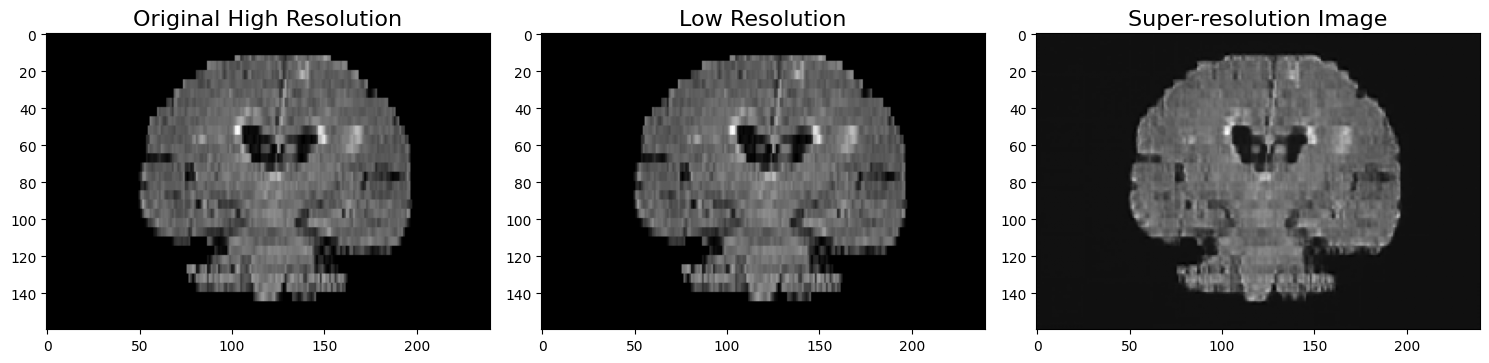

In [7]:
idx = 0
slice = 100
image_ = high_res[idx][0]
low_res_ = low_res[idx][0]
recon_ = recon[idx][0]
plt.figure(figsize=(15,15))

plt.subplot(131)
image_ = np.rot90(image_[:, slice, :])
plt.imshow(image_, cmap='gray')
plt.title('Original High Resolution', fontsize=16)

plt.subplot(132)
low_res_ = np.rot90(low_res_[:, slice, :])
plt.imshow(low_res_, cmap='gray')
plt.title('Low Resolution', fontsize=16)

plt.subplot(133)
recon_ = np.rot90(recon_[:, slice, :])
plt.imshow(recon_, cmap='gray')
plt.title('Super-resolution Image', fontsize=16)

plt.tight_layout()
plt.show()

In [ ]:
idx = 0
slice = 100
image_ = high_res[idx][0]
low_res_ = low_res[idx][0]
recon_ = recon[idx][0]
plt.figure(figsize=(15,15))

plt.subplot(131)
image_ = np.rot90(image_[:, slice, :])
plt.imshow(image_, cmap='gray')
plt.title('Original High Resolution', fontsize=16)

plt.subplot(132)
low_res_ = np.rot90(low_res_[:, slice, :])
plt.imshow(low_res_, cmap='gray')
plt.title('Low Resolution', fontsize=16)

plt.subplot(133)
recon_ = np.rot90(recon_[:, slice, :])
plt.imshow(recon_, cmap='gray')
plt.title('Super-resolution Image', fontsize=16)

plt.tight_layout()
plt.show()

In [9]:
affine

array([[0.9375, 0.    , 0.    , 0.    ],
       [0.    , 0.9375, 0.    , 0.    ],
       [0.    , 0.    , 5.    , 0.    ],
       [0.    , 0.    , 0.    , 1.    ]])

In [1]:
import os, json, torch, random
import numpy as np
from monai import transforms
from monai.data import DataLoader, DistributedSampler
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from monai.networks.nets.swin_unetr import SwinUNETR
from monai.inferers import sliding_window_inference
from functools import partial
import matplotlib.pyplot as plt
from models.SuperFormer import SuperFormer
import nibabel as nib

infer_transform = transforms.Compose([
    
    transforms.CopyItemsd(keys=['path'], names=['image']),
    transforms.LoadImaged(keys=['image']),
    transforms.EnsureChannelFirstd(keys=["image"]),
    transforms.EnsureTyped(keys=["image"]),
    transforms.Orientationd(keys=["image"], axcodes="RAS"),
    transforms.ScaleIntensityRangePercentilesd(keys=["image"], lower=0.5, upper=99.5, b_min=0, b_max=1,clip=True ),
    transforms.Spacingd(keys=['image'],pixdim=(1,1,1),mode="nearest"),
    transforms.CopyItemsd(keys=['image'], names=['hi_res','low_res'], times=2),
    transforms.DeleteItemsd(keys=['image'])])
    
image_path = {'path':"/working/Data/Images/Cerebro_data/nifti_fl_bet/t5648_fl_bet.nii.gz"}
image_data = infer_transform(image_path)

In [2]:
model = SuperFormer(upscale=1,
                   patch_size = 2,
                   in_chans=1,
                   img_size=64,
                   window_size=8,
                   img_range=1.0,
                   depths=[6, 6, 6],
                   embed_dim=240,
                   num_heads=[6, 6, 6],
                   mlp_ratio=2,
                   upsampler=None,
                   resi_connection="1conv",
                   ape=False, 
                   rpb=True,
                   output_type = "direct",
                   num_feat = 126)
model.load_state_dict(torch.load('/working/Project/Sup_Res/checkpoint_superformer/pytorch_model.bin', weights_only=True))
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
model = model.to(device)
device_id = 2  # 对应 "cuda:2"
free_mem, total_mem = torch.cuda.mem_get_info(device_id)
print(f"Device cuda:{device_id} — Free: {free_mem / 1024**2:.2f} MB, Total: {total_mem / 1024**2:.2f} MB")
avail_mem = free_mem / 1024**2
batch_size = np.floor((avail_mem-1200) / 1400).astype(int)
print(f"Batch size: {batch_size}")
model_inferer = partial(
    sliding_window_inference,
    roi_size=[64, 64, 64],
    sw_batch_size=batch_size,
    predictor=model,
    overlap=0.6,
)

Device cuda:2 — Free: 43056.44 MB, Total: 48576.62 MB
Batch size: 29


In [3]:
num_upsample = 1
with torch.no_grad():
    with torch.autocast(device_type="cuda" , dtype=torch.bfloat16):
        path = image_data["path"]
        image = image_data["hi_res"].unsqueeze(0).to(device)
        low_res = image_data["low_res"].unsqueeze(0).to(device)
        print(image.shape)
        for i in range(num_upsample):
            low_res = model_inferer(low_res)
        recon = low_res.squeeze().cpu().float().numpy()
        high_res = image.squeeze().cpu().float().numpy()

torch.Size([1, 1, 240, 240, 163])


In [4]:
basename = os.path.basename(path)
raw_nib = nib.load(path)
spacing = raw_nib.header['pixdim'][1:4]
spacing[2] = 1.0
nib_size = raw_nib.shape
nib_size = list(nib_size)
high_size = high_res.shape
nib_size[2] = high_size[2]
affine = np.eye(4)
affine[:3,:3] = np.diag(spacing)
transfrom_infer = transforms.Compose([
    transforms.EnsureChannelFirst(channel_dim=0),
    transforms.Spacing(pixdim=spacing,mode='bilinear'),
    transforms.ResizeWithPadOrCrop(spatial_size=nib_size),
    ])
recon_image = transfrom_infer(recon[np.newaxis,:,:,:].copy())[0].numpy()
high_res_image = transfrom_infer(high_res[np.newaxis,:,:,:].copy())[0].numpy()
recon_nib = nib.Nifti1Image(recon_image.astype(np.float32),affine)
high_res_nib = nib.Nifti1Image(high_res_image.astype(np.float32),affine)
os.makedirs('temp_low',exist_ok=True)
os.makedirs('temp_recon',exist_ok=True)
nib.save(high_res_nib,os.path.join('temp_low',basename))
nib.save(recon_nib,os.path.join('temp_recon',basename))

In [43]:
class MRIDataset(Dataset):
    def downsample_mri_kspace(self, mri_image, downsampling_factor):
        """
        Downsamples an MRI image using k-space zero-filling.
        """
        # Get the image data and affine transformation
        data = mri_image[0]

        # Get the spatial dimensions
        spatial_dims = data.shape[: len(downsampling_factor)]
        num_spatial_dims = len(spatial_dims)

        # Check if the downsampling factor is valid
        if len(downsampling_factor) != num_spatial_dims:
            raise ValueError(
                f"Downsampling factor length ({len(downsampling_factor)}) must match the number of spatial dimensions ({num_spatial_dims})."
            )
        for factor in downsampling_factor:
            if not isinstance(factor, int) or factor < 1:
                raise ValueError("Downsampling factors must be positive integers.")

        # Perform k-space transform
        k_space = np.fft.fftn(data, axes=range(num_spatial_dims))
        k_space_shifted = np.fft.fftshift(k_space, axes=range(num_spatial_dims))

        # Create a new k-space array with zero-filling
        new_k_space_shape = list(k_space_shifted.shape)

        # Determine the central portion to keep in k-space
        start_indices = []
        end_indices = []
        for i in range(num_spatial_dims):
            center = spatial_dims[i] // 2
            half_kept = (spatial_dims[i] // downsampling_factor[i]) // 2
            start_indices.append(center - half_kept)
            end_indices.append(
                center + (spatial_dims[i] // downsampling_factor[i]) - half_kept
            )
            new_k_space_shape[i] = spatial_dims[i] // downsampling_factor[i]

        # Place the central portion of the original k-space into the new (larger) array
        slices = tuple(
            slice(start, end) for start, end in zip(start_indices, end_indices)
        )
        # downsampled_k_space_shifted[slices] = k_space_shifted[slices]
        downsampled_k_space_shifted = k_space_shifted[slices]

        # Inverse k-space transform to get the downsampled image
        downsampled_k_space = np.fft.ifftshift(
            downsampled_k_space_shifted, axes=range(num_spatial_dims)
        )
        downsampled_data = np.fft.ifftn(
            downsampled_k_space, axes=range(num_spatial_dims)
        ).real
        downsampled_data = downsampled_data[
            np.newaxis, ...
        ]  # Add a new axis to match the original shape

        return downsampled_data

    def __init__(self, image_paths):
        self.image_paths = image_paths
        self.resample_factors = [
            (5, 1, 1),
            (6, 1, 1),
        ]
        self.train_transform_1 = transforms.Compose(
            [
                transforms.Lambda(func=lambda d: {**d, "mask": d["file_name"].replace(".nii.gz", "_mask.nii.gz")}),
                transforms.LoadImaged(keys=["file_name", "mask"]),
                transforms.CopyItemsd(keys=["file_name"], names=["image"]),
                transforms.DeleteItemsd(keys=["file_name"]),
                transforms.EnsureChannelFirstd(keys=["image","mask"]),
                transforms.EnsureTyped(keys=["image","mask"]),
                transforms.Orientationd(keys=["image","mask"], axcodes="RAS"),
                transforms.ScaleIntensityRangePercentilesd(
                    keys=["image"], lower=0.5, upper=99.5, b_min=0, b_max=1, clip=True
                ),
                transforms.Spacingd(keys=["image","mask"], pixdim=(1, 1, 1), mode=3),
                transforms.ResizeWithPadOrCropd(
                    keys=["image","mask"], spatial_size=(240, 240, 180)
                ),
                transforms.CopyItemsd(
                    keys=["image"], names=["hi_res", "low_res"], times=2
                ),
                transforms.DeleteItemsd(keys=["image"]),
            ]
        )
        self.train_transform_2 = transforms.Compose(
            [
                transforms.Resized(
                    keys=["low_res"], spatial_size=(240, 240, 180), mode="nearest"
                ),
                transforms.Lambda(func=lambda d: {
                    **d,
                    "new_res": d["low_res"] * (d["mask"] > 0.2)
                }),
                transforms.CropForegroundd(
                    keys=["hi_res", "low_res"], source_key="mask", allow_smaller=False
                ),
                # transforms.RandSpatialCropd(
                #     keys=["hi_res", "low_res"], roi_size=(64, 64, 64), random_size=False
                # ),
            ]
        )

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        data = self.image_paths[idx]
        transformed_data = self.train_transform_1(data)
        transformed_data["low_res"] = self.downsample_mri_kspace(
            transformed_data["low_res"], random.choice(self.resample_factors)
        )
        transformed_data = self.train_transform_2(transformed_data)
        return transformed_data

In [45]:
with open("json/train_files4.json") as f:
    train_files = json.load(f)
train_ds = MRIDataset(train_files)

In [46]:
temp_data = train_ds[100]

In [47]:
print(temp_data.keys())

dict_keys(['mask', 'hi_res', 'low_res', 'new_res', 'foreground_start_coord', 'foreground_end_coord'])


In [28]:
import matplotlib.pyplot as plt
import numpy as np

In [29]:
low = temp_data['low_res'].numpy()
print(low.shape)

(1, 240, 240, 180)


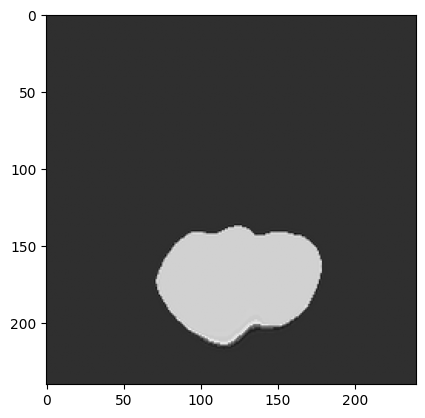

In [48]:
plt.imshow(np.rot90(temp_data['mask'].numpy()[0, :, :, 32]), cmap='gray')
plt.show()

In [49]:
print(temp_data['mask'].numpy()[0, 0, 1, 32])

-0.0


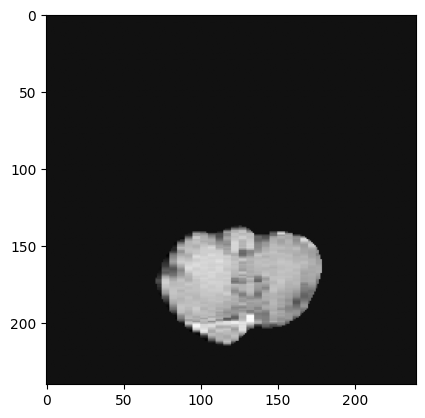

In [50]:
plt.imshow(np.rot90(temp_data['new_res'].numpy()[0, :, :, 32]), cmap='gray')
plt.show()

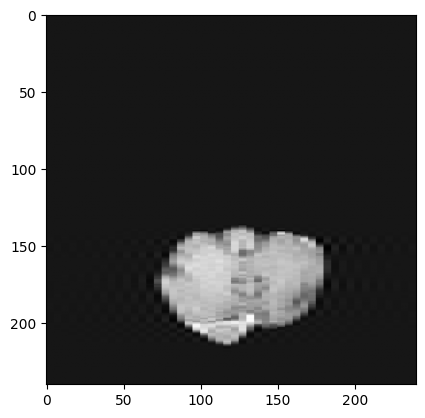

In [51]:
plt.imshow(np.rot90(temp_data['low_res'].numpy()[0, :, :, 32]), cmap='gray')
plt.show()